In [46]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, GlobalAveragePooling1D
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [48]:
train_data = pd.read_csv('text_emotion.csv')

In [49]:
train_data.head()

,sentiment,content
0,joy,[ On days when I feel close to my partner and ...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [50]:
train_data['target'] = train_data.sentiment.astype('category').cat.codes

In [51]:
train_data['num_words'] = train_data.content.apply(lambda x : len(x.split()))

In [52]:
bins=[0,50,75, np.inf]
train_data['bins']=pd.cut(train_data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [53]:
word_distribution = train_data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [54]:
word_distribution.head()

,bins,counts
0,0-100,7630
1,100-300,22
2,300-500,0
3,500-800,0
4,>800,0


Text(0.5, 1.0, 'Word distribution per bin')

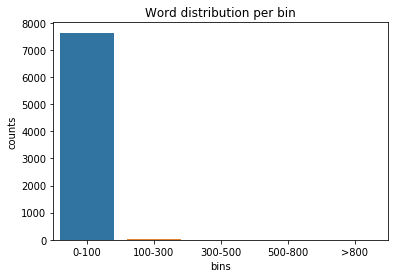

In [55]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [91]:
train_data.content

0       [ On days when I feel close to my partner and ...
1       Every time I imagine that someone I love or I ...
2       When I had been obviously unjustly treated and...
3       When I think about the short time that we live...
4       At a gathering I found myself involuntarily si...
5       When I realized that I was directing the feeli...
6       I feel guilty when when I realize that I consi...
7       After my girlfriend had taken her exam we went...
8       When, for the first time I realized the meanin...
9       When a car is overtaking another and I am forc...
10      When I recently thought about the hard work it...
11        When I found a bristle in the liver paste tube.
12      When I was tired and unmotivated, I shouted at...
13      When I think that I do not study enough.  Afte...
14      When I pass an examination which I did not thi...
15      When one has arranged to meet someone and that...
16      When one is unjustly accused of something one ...
17      When o

In [72]:
num_class = len(np.unique(train_data.sentiment.values))
y = train_data['target'].values
num_class

7

In [73]:
MAX_LENGTH = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.content.values)
post_seq = tokenizer.texts_to_sequences(train_data.content.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)
y_train

array([3, 6, 4, ..., 0, 4, 0], dtype=int8)

In [75]:
vocab_size = len(tokenizer.word_index) + 1

In [86]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 100, 128)          1171840   
_________________________________________________________________
flatten_18 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                409632    
_________________________________________________________________
dense_37 (Dense)             (None, 7)                 231       
Total params: 1,581,703
Trainable params: 1,581,703
Non-trainable params: 0
_________________________________________________________________
Train on 5451 samples, validate on 1818 samples
Epoch 1/5
5451/5451 [==============================] - 3s 554us/step - loss: 1.9409 

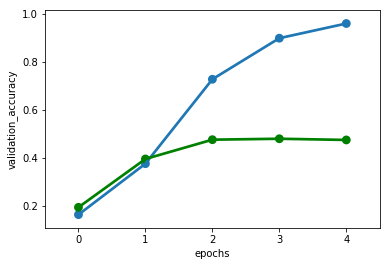

In [87]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [88]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.48825065274151436

In [89]:
predicted

array([1, 2, 4, 0, 4, 6, 5, 0, 6, 0, 5, 5, 1, 0, 0, 3, 5, 1, 1, 2, 3, 3,
       1, 0, 2, 5, 4, 2, 1, 3, 6, 0, 2, 5, 6, 4, 0, 6, 5, 3, 1, 4, 1, 5,
       3, 5, 6, 1, 4, 4, 2, 0, 6, 3, 1, 5, 1, 3, 5, 6, 2, 4, 2, 1, 0, 1,
       2, 2, 3, 3, 2, 0, 4, 4, 4, 3, 6, 1, 3, 3, 5, 0, 1, 0, 5, 6, 2, 0,
       2, 2, 5, 4, 3, 3, 5, 3, 3, 3, 2, 5, 4, 2, 4, 2, 5, 1, 6, 5, 6, 5,
       1, 1, 2, 2, 5, 5, 6, 2, 4, 4, 6, 0, 6, 5, 5, 2, 5, 6, 6, 5, 2, 0,
       4, 4, 4, 4, 2, 2, 4, 3, 2, 5, 3, 6, 1, 4, 1, 4, 2, 4, 2, 5, 5, 0,
       3, 4, 3, 4, 4, 3, 4, 1, 5, 1, 5, 6, 5, 5, 6, 3, 0, 2, 2, 6, 5, 0,
       4, 5, 6, 4, 4, 0, 3, 4, 0, 5, 1, 0, 0, 4, 2, 0, 1, 5, 0, 4, 2, 0,
       0, 5, 1, 2, 4, 0, 6, 1, 2, 4, 1, 0, 0, 6, 5, 6, 2, 6, 2, 2, 4, 0,
       2, 3, 6, 6, 1, 3, 5, 2, 4, 4, 2, 4, 1, 3, 2, 2, 5, 3, 4, 3, 6, 2,
       6, 1, 1, 3, 6, 1, 1, 4, 2, 1, 3, 5, 2, 6, 3, 6, 3, 2, 2, 2, 1, 3,
       4, 5, 6, 1, 6, 4, 2, 3, 1, 5, 4, 5, 3, 5, 0, 3, 4, 6, 6, 2, 2, 5,
       2, 2, 5, 1, 6, 3, 2, 5, 3, 4, 0, 6, 5, 5, 1,

In [90]:
y_test

array([1, 2, 4, 3, 4, 3, 5, 0, 6, 3, 0, 4, 1, 6, 0, 6, 0, 1, 1, 2, 0, 3,
       1, 4, 2, 5, 4, 2, 1, 3, 3, 0, 2, 6, 2, 4, 0, 2, 5, 3, 4, 1, 4, 5,
       2, 1, 6, 6, 4, 0, 4, 5, 0, 6, 1, 6, 3, 3, 3, 5, 4, 4, 4, 0, 1, 2,
       2, 1, 6, 0, 2, 3, 4, 4, 5, 2, 6, 2, 4, 0, 5, 1, 1, 0, 5, 6, 2, 0,
       3, 2, 5, 0, 4, 6, 0, 1, 6, 1, 2, 1, 2, 2, 4, 2, 3, 6, 6, 1, 6, 0,
       1, 3, 2, 2, 5, 5, 6, 2, 4, 6, 6, 0, 6, 5, 5, 6, 4, 6, 1, 5, 2, 0,
       4, 2, 1, 1, 1, 2, 1, 0, 2, 5, 2, 6, 6, 6, 1, 1, 2, 4, 2, 5, 2, 3,
       0, 4, 3, 5, 5, 3, 4, 1, 5, 6, 5, 3, 2, 0, 3, 3, 3, 2, 2, 0, 5, 1,
       4, 1, 0, 4, 6, 2, 3, 6, 1, 4, 0, 5, 0, 4, 4, 6, 4, 3, 6, 0, 0, 0,
       6, 5, 1, 2, 5, 5, 2, 0, 2, 4, 1, 0, 1, 6, 2, 4, 6, 5, 5, 2, 3, 0,
       2, 3, 6, 6, 1, 3, 0, 2, 2, 0, 2, 4, 1, 3, 2, 2, 5, 3, 4, 3, 0, 1,
       5, 0, 1, 3, 6, 0, 6, 4, 2, 1, 5, 5, 2, 0, 2, 3, 3, 3, 2, 5, 3, 3,
       4, 5, 3, 0, 6, 3, 2, 0, 2, 6, 4, 4, 3, 0, 2, 6, 4, 0, 0, 2, 6, 5,
       2, 5, 6, 3, 2, 5, 2, 1, 6, 5, 5, 3, 0, 3, 1,